# Phase II : Data cleaning & Feature engineering

<hr/>

## I. Importation des Librairies utiles
<p>Plusieurs librairies sont utiles tout au long de l'étude. Elles sont importées dans cette section.</p>

In [1]:
# librairies pour ne pas afficher les warning
import warnings
warnings.filterwarnings('ignore')

# librairies pour les graphes
%pylab  inline
import seaborn as sns

# librairies pour les analyses
import pandas as pd
import numpy as np
import math

# autres librairies
import glob
import gc
import time
from contextlib import contextmanager

Populating the interactive namespace from numpy and matplotlib


<hr/>

## II. Feature engineering

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
from sklearn.impute import SimpleImputer

# Imput missing values with SimpleImputer using 'mode' for categorical features
# and using 'median' as initial strategy for numerical features
def imput_nan(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    if categorical_columns:
        df[categorical_columns] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_columns])    
    numerical_columns = [col for col in df.columns if (col not in categorical_columns) and (col not in ['SK_ID_CURR','TARGET'])]
    if numerical_columns:
        df[numerical_columns]  = SimpleImputer(strategy='median').fit_transform(df[numerical_columns])    
    return df

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
# Preprocess application_train.csv and application_test.csv
def application(test = False, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../Dataset/application_train.csv', nrows= num_rows)
    if test :
        test_df = pd.read_csv('../Dataset/application_test.csv', nrows= num_rows)
        print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
        df = df.append(test_df).reset_index(drop=True)
        del test_df
    else :
        print("Train samples: {}".format(len(df)))
    
    # Imputing Missing-values
    df = imput_nan(df)
    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../Dataset/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../Dataset/bureau_balance.csv', nrows = num_rows)
    # Imputing Missing-values
    bureau = imput_nan(bureau)
    bb = imput_nan(bb)
    
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['mean'],#['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],#['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],#['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean'],#['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean'],#['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean'],#['mean', 'sum'],
        'AMT_ANNUITY': ['mean'],#['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean']#['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../Dataset/previous_application.csv', nrows = num_rows)
    prev = imput_nan(prev)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['mean'],#['min', 'max', 'mean'],
        'AMT_APPLICATION': ['mean'],#['min', 'max', 'mean'],
        'AMT_CREDIT': ['mean'],#['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['mean'],#['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['mean'],#['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['mean'],#['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['mean'],#['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['mean'],#['min', 'max', 'mean'],
        'DAYS_DECISION': ['mean'],#['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean']#['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../Dataset/POS_CASH_balance.csv', nrows = num_rows)
    pos = imput_nan(pos)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['mean'],#['max', 'mean', 'size'],
        'SK_DPD': ['mean'],#['max', 'mean'],
        'SK_DPD_DEF': ['mean']#: ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../Dataset/installments_payments.csv', nrows = num_rows)
    ins = imput_nan(ins)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['mean'],#['max', 'mean', 'sum'],
        'DBD': ['mean'],#['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['mean'],#['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['mean'],#['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['mean'],#['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['mean'],#['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['mean']#['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../Dataset/credit_card_balance.csv', nrows = num_rows)
    cc = imput_nan(cc)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['mean'])#['min', 'max', 'mean', 'sum', 'var']
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
def load_data(test = False,debug = False):
    num_rows = 150000 if debug else None
    df = application(test,num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    return df

In [12]:
data = load_data(test = True,debug = True)

Train samples: 150000, test samples: 48744
Bureau df shape: (34117, 74)
Process bureau and bureau_balance - done in 3s
Previous applications df shape: (110071, 187)
Process previous_applications - done in 7s
Pos-cash balance df shape: (104063, 11)
Process POS-CASH balance - done in 1s
Installments payments df shape: (58741, 9)
Process installments payments - done in 1s
Credit card balance df shape: (64370, 27)
Process credit card balance - done in 2s


In [13]:
data.shape

(198741, 556)

In [14]:
data.head(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_SK_DPD_MEAN,CC_SK_DPD_DEF_MEAN,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
0,0.0,100002,1.0,0,0,0,0.0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,100003,0.0,1,0,1,0.0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,100004,0.0,0,1,0,0.0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<hr/>

## III. Feature selection

In [15]:
print('Missing values in data: ', sum(data.isnull().sum()))

Missing values in data:  47211171


* Clean data

In [16]:
test_index = data[data['TARGET'].isnull()].index

In [17]:
test_index

Int64Index([150000, 150001, 150002, 150003, 150004, 150005, 150006, 150007,
            150008, 150009,
            ...
            198734, 198735, 198736, 198737, 198738, 198739, 198740, 198741,
            198742, 198743],
           dtype='int64', length=48744)

In [18]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data[data==np.inf]=np.nan
data.fillna(data.median(), inplace=True)

In [19]:
data.shape

(198741, 556)

* Split Target & other Features

In [20]:
X = data.drop(['SK_ID_CURR','TARGET'], axis=1)
y = data.TARGET
feature_name = X.columns.tolist()

* Feature Selection with CORRELATION

In [21]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [22]:
cor_support, cor_feature = cor_selector(X, y)

* Feature Selection with CHI2

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100).fit(X_norm, y)

In [24]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

* Feature Selection with wrapper(RFE)

In [25]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=100, verbose=5).fit(X_norm, y)

Fitting estimator with 554 features.
Fitting estimator with 454 features.
Fitting estimator with 354 features.
Fitting estimator with 254 features.
Fitting estimator with 154 features.


In [26]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

* Feature Selection with Logistic regression

In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), '1.25*median').fit(X_norm, y)

In [28]:
lr_support = lr_selector.get_support()
lr_feature = X.loc[:,lr_support].columns.tolist()

* Feature Selection with Random Forest

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median').fit(X, y)

In [30]:
rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()

* Feature Selection with LightLGBM

In [31]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgb_selector = SelectFromModel(lgbc, threshold='1.25*median').fit(X, y)

In [32]:
lgb_support = lgb_selector.get_support()
lgb_feature = X.loc[:,lgb_support].columns.tolist()

* Summary

In [33]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name,'Pearson':cor_support,'Chi-2':chi_support,'RFE':rfe_support,
                                     'Logistics':lr_support,'Random Forest':rf_support,'LightGBM':lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [34]:
feature_selection_df[feature_selection_df.Total>=4]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,index,True,True,True,True,True,True,6
2,REGION_RATING_CLIENT_W_CITY,True,True,True,True,True,True,6
3,NAME_INCOME_TYPE_Pensioner,True,True,True,True,True,True,6
4,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,True,True,True,True,True,True,6
5,FLOORSMAX_MEDI,True,True,True,True,True,True,6
6,FLAG_EMAIL,True,True,True,True,True,True,6
7,FLAG_DOCUMENT_3,True,True,True,True,True,True,6
8,EXT_SOURCE_3,True,True,True,True,True,True,6
9,EXT_SOURCE_2,True,True,True,True,True,True,6
10,EXT_SOURCE_1,True,True,True,True,True,True,6


In [35]:
selected_features = list(feature_selection_df[feature_selection_df.Total>=4]['Feature'])

In [53]:
#selected_features.remove('index')

In [36]:
selected_features.extend(['SK_ID_CURR','TARGET'])

<AxesSubplot:>

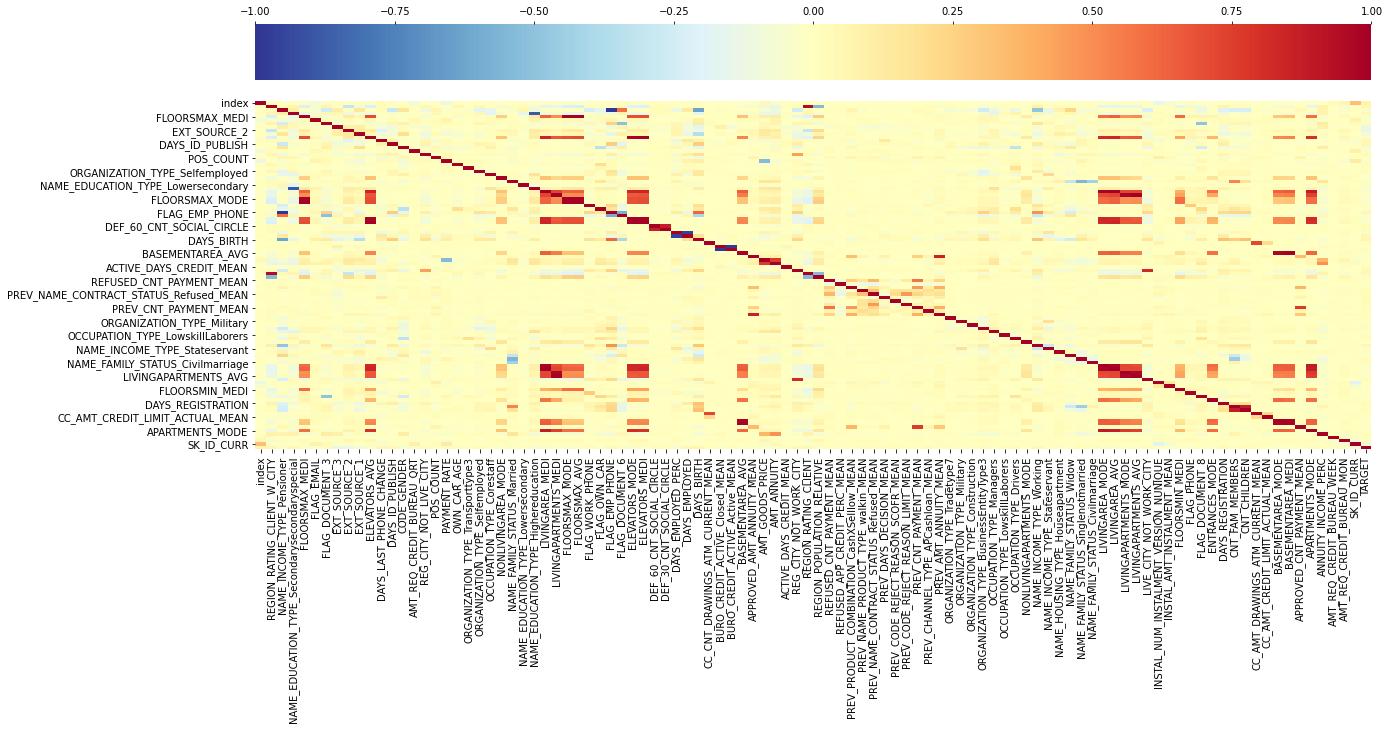

In [37]:
fig = plt.subplots(figsize=(20,8))
sns.heatmap(data[selected_features].corr(),cmap=plt.cm.RdYlBu_r,vmin=-1,vmax=1,cbar_kws = dict(use_gridspec=False,location="top"))

<hr/>

## IV. Sauvegarde des données

* ensemble de données cleanés

In [39]:
data.loc[test_index, ['TARGET']] = np.nan

In [49]:
data.shape

(198741, 555)

In [50]:
data.to_csv(path_or_buf='../Results/data_all.csv',index=False)

* selection features données cleanés

In [56]:
df = data[selected_features]

In [57]:
df.shape

(198741, 101)

In [58]:
df.to_csv(path_or_buf='../Results/data_selected.csv',index=False)

* train cleanés

In [59]:
train = df[df.TARGET.isnull() == False]

In [60]:
train.shape

(149997, 101)

In [61]:
train.to_csv(path_or_buf='../Results/data_train.csv',index=False)

* test cleanés

In [62]:
test = df[df.TARGET.isnull()]

In [63]:
test.shape

(48744, 101)

In [64]:
test.to_csv(path_or_buf='../Results/data_test.csv',index=False)